# Mask R-CNN for organ segmentation

### Getting access to the data stored in the drive

In [ ]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/akTwelve/Mask_RCNN.git
# pip install pycocotools

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 137.72 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (570/570), done.
Checking out files: 100% (76/76), done.


### Importing the librairies

In [ ]:
from skimage.io import imread
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os

### Defining the directory root

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/"

In [ ]:
MASK_RCNN_DIR = os.path.join(ROOT_DIR, "Projet_DL2/Mask_RCNN/")

In [ ]:
cd /content/drive/MyDrive/Projet_DL2/Mask_RCNN/samples  

/content/drive/MyDrive/Projet_DL2/Mask_RCNN/samples


## Converting the annotations to the recquired format

### Download the raw annotations

In [ ]:
train = pd.read_csv('train.csv', sep=',', header=0)

In [ ]:
# printing the 3 classes

print(train['class'][0])
print(train['class'][1])
print(train['class'][2])

large_bowel
small_bowel
stomach


### Pre-processing : moving to the COCO annotation format using clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as hcluster

pixel_value = {"stomach": 1, 'large_bowel': 2, 'small_bowel': 3}

thresh = 1.1

def annotations(type,annot_csv = train):
 
    annotation = {}
    for annot_id in os.listdir(type):

      # Load the image

      img_path = type + "/" + annot_id
      annot_id = annot_id[:-4]
      img = imread(img_path)
      w, h = img.shape
  
      img_mask = np.zeros_like(img)
      img_mask2 = np.zeros_like(img)
      annot = annot_csv
      annot = annot[annot.id == annot_id]
      annot.dropna(inplace=True) 

      image_annot_json = {}
      image_annot_json['filename'] = annot_id + '.png'


      region = []
      image_annot_json['regions'] = region
      image_annot_json['size'] = w*h
      
      for organ in annot['class'].unique():

          x_list = []
          y_list = []

          organ_annot = annot[annot['class'] == organ]
          color = pixel_value[organ]
          pixels = organ_annot["segmentation"].values[0].split(' ')

          # retreiving the annotated pixels

          for i in range(0, len(pixels) - 1, 2):
              pix1, nbr_pix = int(pixels[i]), int(pixels[i + 1])
              i, j = pix1//h, pix1%h
              img_mask[i-1, j-1:j+nbr_pix] = color

              k=0
              while k < nbr_pix:
              
                y_list.append(i)
                y_list.append(i)

                x_list.append(j)
                x_list.append(j+k) 
                k+=1


          data = list(zip(x_list, y_list))

          # performing clustering in order to extract each organ

          clusters = hcluster.fclusterdata(data, thresh, criterion="distance")

          nb_organs = max(clusters)

          classe = 1

          # Build the dictionanary

          while (classe <= nb_organs):

            y_list_polygon = []
            x_list_polygon = []

            for i in range(len(clusters)):
              if clusters[i]==(classe):
                x_list_polygon.append(x_list[i])
                y_list_polygon.append(y_list[i])

            if x_list_polygon != [] :
              dict_organ = {}
              dict_organ['region_attributes'] = {'name' : organ}
              form = {}
              form['name'] = 'polygon'
              form['all_points_x'] = y_list_polygon
              form['all_points_y'] = x_list_polygon


              dict_organ['shapes_attributes'] = form

              region.append(dict_organ)
            
            classe += 1

      # Update the dictionnary

      if image_annot_json['regions'] != []:
        annotation[annot_id] = image_annot_json

    return annotation


## Annotating the training and the validation set

#### Training set

In [ ]:
annotations_train = annotations(type = "train")

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
np.save("train/annotations",annotations_train)

#### Validation set

In [ ]:
annotations_val = annotations(type = "val")

In [ ]:
np.save("val/annotations",annotations_val)

### Plotting the masks

### Importing the Mask R-CNN model

In [ ]:
cd "/content/drive/MyDrive/Projet_DL2/Mask_RCNN/"

/content/drive/MyDrive/Projet_DL2/Mask_RCNN


In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = "/content/drive/MyDrive/"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(sys.path.append(ROOT_DIR))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

None
/content/drive/MyDrive/logs
/content/drive/MyDrive/mask_rcnn_coco.h5


### Define the model configuration

In [ ]:
class ScansConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "organ"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 266
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ScansConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  266
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Defining the DataLoader

In [ ]:
class ScansDataset(utils.Dataset):

    def load_VIA(self, dataset_dir, subset, hc=False):

        """Load the UW Madison dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val or predict
        """
        # Classes
        self.add_class("organ", 1, "stomach")
        self.add_class("organ", 2, "large_bowel")
        self.add_class("organ", 3, "small_bowel")
        if hc is True:
            for i in range(1,14):
                self.add_class("surgery", i, "{}".format(i))
            self.add_class("surgery", 14, "arm")

        # Train or validation dataset?
        assert subset in ["train", "val", "predict"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # Each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {name:'a'},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region

        a_path = dataset_dir + "/" + "annotations.npy"
        annotations = np.load(a_path,allow_pickle=True).item() #json.load(open(os.path.join(dataset_dir, "via_region_data.json")))

        #annotations = list(annotations.values())  # don't need the dict keys
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        print(annotations)
        annotations = [annotations[key] for key in annotations.keys() if annotations[key]['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shapes_attributes'] for r in a['regions']]
            names = [r['region_attributes'] for r in a['regions']]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename']) 
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "organ",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                names=names)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "organ":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        class_names = info["names"]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_x'], p['all_points_y'])
            mask[rr, cc, i] = 1
        # Assign class_ids by reading class_names
        class_ids = np.zeros([len(info["polygons"])])
     
        for i, p in enumerate(class_names):
        #"name" is the attributes name decided when labeling, etc. 'region_attributes': {name:'a'}
            if p['name'] == 'stomach':
                class_ids[i] = 1
            elif p['name'] == 'large_bowel':
                class_ids[i] = 2
            elif p['name'] == 'small_bowel':
                class_ids[i] = 3
            #assert code here to extend to other labels
        class_ids = class_ids.astype(int)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "organ":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def load_mask_hc(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
   
        image_info = self.image_info[image_id]
        if image_info["source"] != "organ":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        #"name" is the attributes name decided when labeling, etc. 'region_attributes': {name:'a'}
        class_names = info["names"]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_x'], p['all_points_y'])
            mask[rr, cc, i] = 1
        # Assign class_ids by reading class_names
        class_ids = np.zeros([len(info["polygons"])])
        
        for i, p in enumerate(class_names):
            if p['name'] == 'arm':
                class_ids[i] = 14
            elif p['name'] == 'error':
                pass
            else:
                class_ids[i] = int(p['name'])
            #assert code here to extend to other labels
        class_ids = class_ids.astype(int)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids


## Inspect the dataset

In [ ]:
ROOT_DIR

'/content/drive/MyDrive/'

In [ ]:
ORGAN_DIR = os.path.join(ROOT_DIR, "Projet_DL2/Mask_RCNN/samples")

In [ ]:
import skimage.draw

dataset = ScansDataset()
dataset.load_VIA(ORGAN_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

{'case91_day0_slice_0101': {'filename': 'case91_day0_slice_0101.png', 'regions': [{'region_attributes': {'name': 'large_bowel'}, 'shapes_attributes': {'name': 'polygon', 'all_points_x': [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 6

<ipython-input-49-a6f58faeb63c>:106: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids


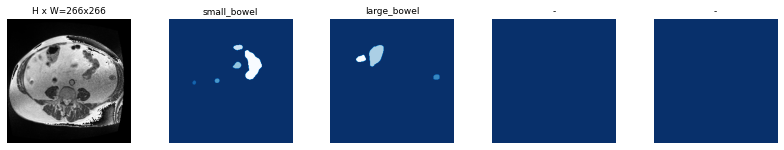

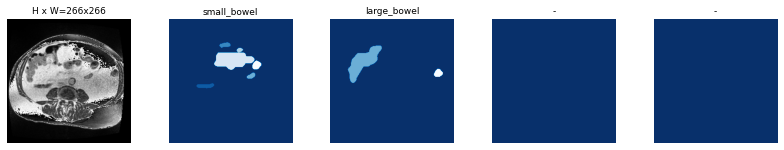

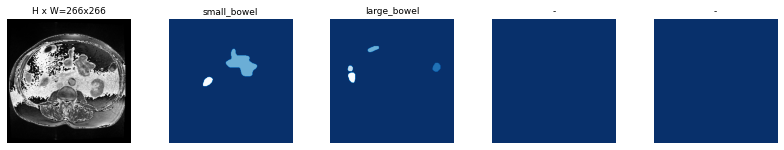

In [ ]:
# Load and display random samples
image_ids =[8,15,19] # np.random.choice(dataset.image_ids, 4) 
for image_id in image_ids:

    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

<ipython-input-49-a6f58faeb63c>:106: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids


image_id  8 /content/drive/MyDrive/Projet_DL2/Mask_RCNN/samples/train/case91_day0_slice_0112.png
image                    shape: (266, 266, 3)         min:    0.00000  max:  523.00000  uint16
mask                     shape: (266, 266, 8)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (8,)                  min:    2.00000  max:    3.00000  int64
bbox                     shape: (8, 4)                min:   50.00000  max:  235.00000  int32


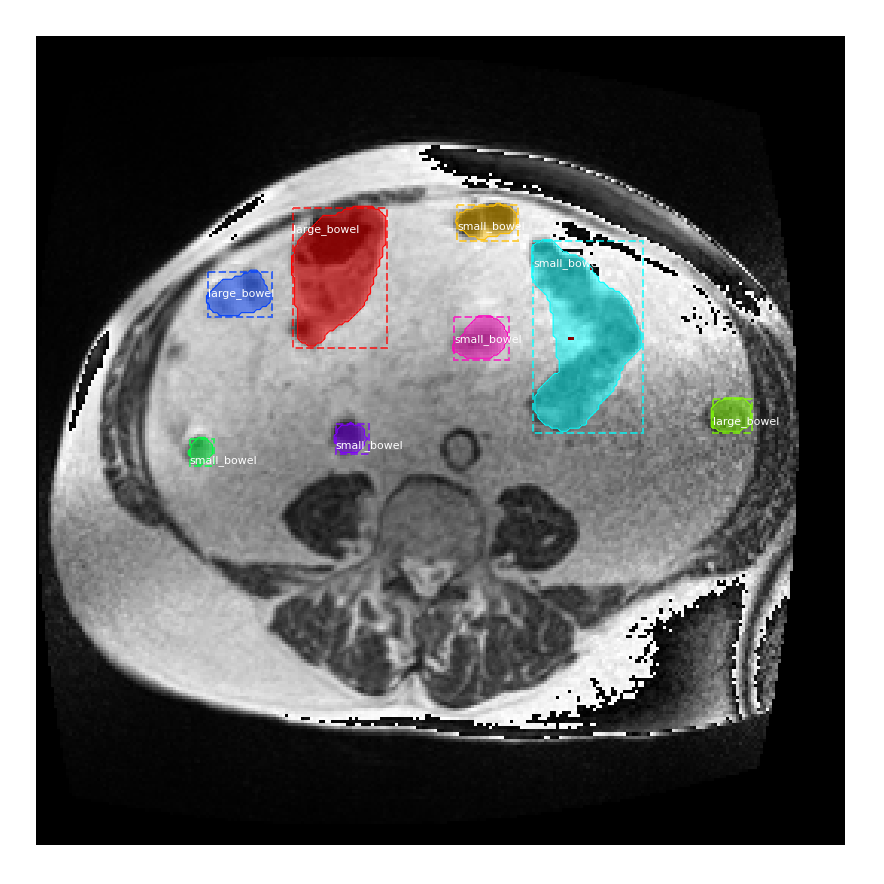

In [ ]:
# Load random image and mask.
image_id = 8 #random.choice(dataset.image_ids) #160-142 # 21 bizarre case123_day0_slice_0093 # 234 case92_day0_slice_0103 # 258 case92_day0_slice_0108 # 132 case90_day0_slice_0116
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

image.shape
#img = imread("/content/drive/MyDrive/Projet_DL/Mask_RCNN/samples/train/case80_day0_slice_0100.png")
#fig, axes = plt.subplots(1, 2, figsize=(20, 15))
    # Plot image 
#axes[0].imshow(img, cmap='gray')



# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Training on a little dataset

In [ ]:
import skimage.draw
# Training dataset 
dataset_train = ScansDataset()
dataset_train.load_VIA(ORGAN_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ScansDataset()
dataset_val.load_VIA(ORGAN_DIR, "val")
dataset_val.prepare()

{'case91_day0_slice_0101': {'filename': 'case91_day0_slice_0101.png', 'regions': [{'region_attributes': {'name': 'large_bowel'}, 'shapes_attributes': {'name': 'polygon', 'all_points_x': [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 6

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 1


In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads',custom_callbacks = None) 


Starting at epoch 1. LR=0.001

Checkpoint Path: /content/drive/MyDrive/logs/organ20230117T1124/mask_rcnn_organ_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


KeyboardInterrupt: ignored

### Predicting the organs location

In [ ]:
class InferenceConfig(ScansConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/drive/MyDrive/logs/organ20230117T1124/mask_rcnn_organ_0001.h5
Re-starting from epoch 1


In [ ]:
cd "/content/drive/MyDrive/Projet_DL2/Mask_RCNN/samples"

/content/drive/MyDrive/Projet_DL2/Mask_RCNN/samples


<ipython-input-49-a6f58faeb63c>:106: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


image ID: organ.case92_day0_slice_0089.png (5) /content/drive/MyDrive/Projet_DL2/Mask_RCNN/samples/train/case92_day0_slice_0089.png
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  635.00000  uint16
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  531.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    3.00000  int64
gt_bbox                  shape: (9, 4)                min:  180.00000  max:  348.00000  int32
gt_mask                  shape: (56, 56, 9)           min:    0.00000  max:    1.00000  bool


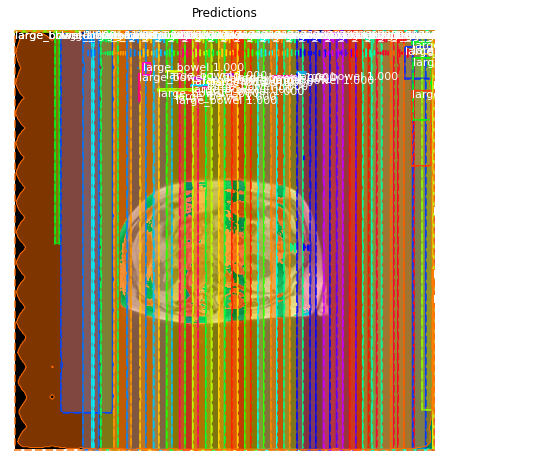

In [ ]:
image_id = random.choice(dataset_train.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_train, config, image_id)#, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
dataset_train.image_reference(image_id)))

results = model.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
dataset_train.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)